<a href="https://colab.research.google.com/github/VatsalyaDubey16/Transfer_Learning_Models/blob/main/Scaling_UP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Wed Mar 20 12:17:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In [3]:

!wget https://raw.githubusercontent.com/VatsalyaDubey16/Transfer_Learning_Models/main/helper_functions.py

--2024-03-20 12:17:30--  https://raw.githubusercontent.com/VatsalyaDubey16/Transfer_Learning_Models/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-20 12:17:30 (89.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-03-20 12:17:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.207, 172.217.214.207, 172.253.114.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   178MB/s    in 8.9s    

2024-03-20 12:17:40 (175 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
# how many images classes are there
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/carrot_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/strawberry_shortcake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fried_calamari'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macarons'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lasagna'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/clam_chowder'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '101

In [7]:
# Setup data inputs
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes



In [8]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                     save_weights_only = True,
                                     monitor = 'val_accuracy',
                                     save_best_only = True)

In [9]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomZoom(0.2)
], name = 'data_augmentation')

In [10]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB7(include_top = False)
base_model.trainable = False

# Setup model architecutre with trainable top layers
inputs = layers.Input(shape = (224,224,3) , name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training = False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name = 'global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = 'softmax', name = 'output_layer')(x)
model = tf.keras.Model(inputs, outputs)


258076736/258076736 [==============================] - 1s 0us/step


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 224, 3)      0         
 ial)                                                            
                                                                 
 efficientnetb7 (Functional  (None, None, None, 2560   64097687  
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 2560)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               258661    
                                                             

In [12]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

history_1 = model.fit(train_data_all_10_percent,
                      epochs = 5,
                      validation_data = test_data,
                      validation_steps = int(0.15*len(test_data)),
                      callbacks = [checkpoint_callback] )

Epoch 1/5
237/237 [==============================] - 202s 742ms/step - loss: 3.2695 - accuracy: 0.2861 - val_loss: 2.4487 - val_accuracy: 0.4296
Epoch 2/5
237/237 [==============================] - 134s 565ms/step - loss: 2.2254 - accuracy: 0.4692 - val_loss: 2.0765 - val_accuracy: 0.4891
Epoch 3/5
237/237 [==============================] - 136s 571ms/step - loss: 1.9076 - accuracy: 0.5233 - val_loss: 1.9000 - val_accuracy: 0.5252
Epoch 4/5
237/237 [==============================] - 127s 535ms/step - loss: 1.7122 - accuracy: 0.5703 - val_loss: 1.8950 - val_accuracy: 0.5177
Epoch 5/5
237/237 [==============================] - 126s 529ms/step - loss: 1.5766 - accuracy: 0.6029 - val_loss: 1.7954 - val_accuracy: 0.5405


In [13]:
# Evaluate on the whole dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 276s 349ms/step - loss: 1.6303 - accuracy: 0.5726


[1.6303292512893677, 0.572633683681488]

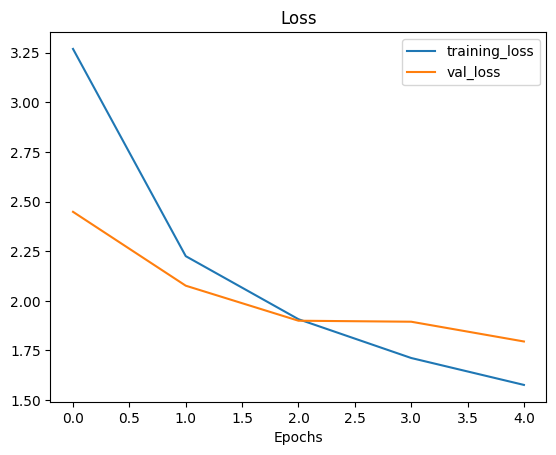

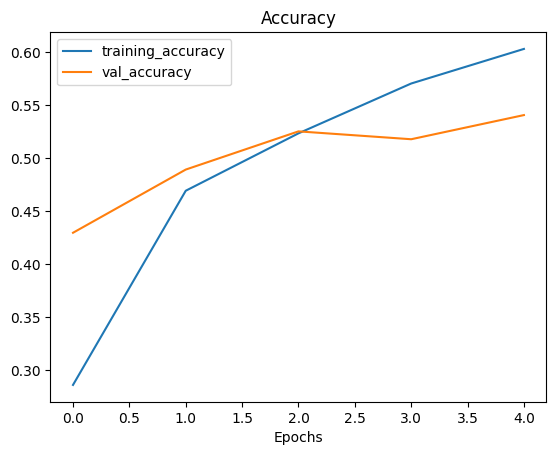

In [14]:
plot_loss_curves(history_1)

## Fine-tuning

In [15]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layers in base_model.layers[:-5]:
  layers.trainable = False

In [16]:
# Recompile model with lower training rate
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
              metrics = ['accuracy'])

In [17]:
# What layer in the model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb7 True
global_avg_pool_layer True
output_layer True


In [18]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block1c_dwconv False
31 block1c_bn False
32 block1c_activation False
33 block1c_se_squeeze False
34 block1c_se_reshape False
35 block1c_se_reduce False
36 block1c_se_expand False
37 block1c_se_excite False
38 block1c_project_conv False
39 block1c_project_bn False
40

In [19]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

# Fine-tune our model
history_2 = model.fit(train_data_all_10_percent,
                      epochs = fine_tune_epochs,
                      validation_data = test_data,
                      validation_steps = int(0.15*len(test_data)),
                      initial_epoch = history_1.epoch[-1])

Epoch 5/10
237/237 [==============================] - 199s 750ms/step - loss: 1.7590 - accuracy: 0.5391 - val_loss: 1.8577 - val_accuracy: 0.5148
Epoch 6/10
237/237 [==============================] - 127s 535ms/step - loss: 1.2983 - accuracy: 0.6461 - val_loss: 1.8373 - val_accuracy: 0.5283
Epoch 7/10
237/237 [==============================] - 129s 540ms/step - loss: 1.0344 - accuracy: 0.7092 - val_loss: 1.7517 - val_accuracy: 0.5625
Epoch 8/10
237/237 [==============================] - 127s 533ms/step - loss: 0.8201 - accuracy: 0.7634 - val_loss: 1.9057 - val_accuracy: 0.5373
Epoch 9/10
237/237 [==============================] - 124s 521ms/step - loss: 0.6644 - accuracy: 0.8067 - val_loss: 1.9153 - val_accuracy: 0.5543
Epoch 10/10
237/237 [==============================] - 125s 526ms/step - loss: 0.5335 - accuracy: 0.8433 - val_loss: 2.0393 - val_accuracy: 0.5328


In [20]:
# Evaluate on the whole test data
all_data_ev = model.evaluate(test_data)
all_data_ev

790/790 [==============================] - 280s 354ms/step - loss: 1.8192 - accuracy: 0.5746


[1.819243311882019, 0.5746138691902161]

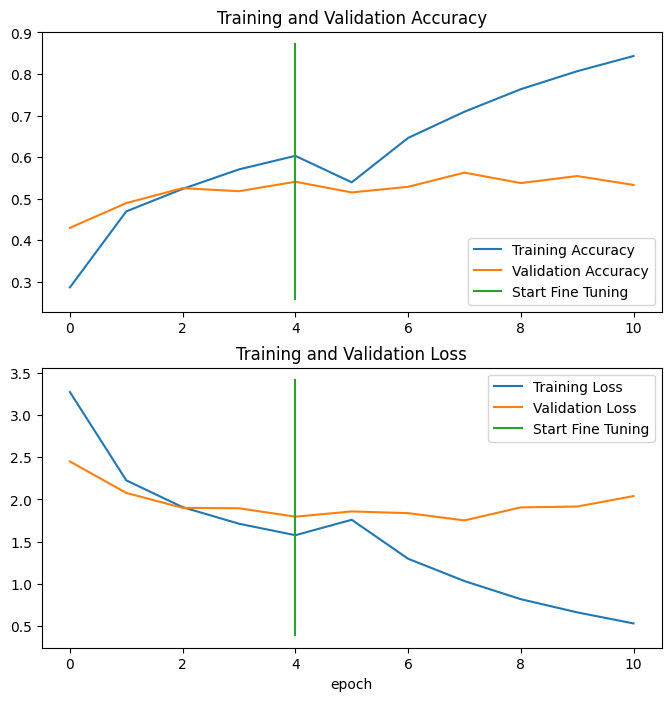

In [21]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history = history_1,
                 new_history = history_2,
                 initial_epochs = 5)

In [22]:
# Evaluate on the whole test dataset
all_data_ev2 = model.evaluate(test_data)

790/790 [==============================] - 280s 355ms/step - loss: 1.8192 - accuracy: 0.5746


## Making predictions with our trained model

In [23]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose =1 )

790/790 [==============================] - 274s 341ms/step


In [24]:
# Will return batches
len(test_data)

790

In [25]:
# how many predictions are there
len(preds_probs)

25250

In [26]:
# What is shape of our predictions?
preds_probs.shape

(25250, 101)

In [27]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[1.44327030e-04, 3.87274849e-06, 1.16889868e-02, ...,
        4.59327110e-09, 2.58682691e-03, 4.49484560e-06],
       [2.32278362e-01, 2.82693986e-06, 2.76587531e-03, ...,
        1.81587495e-07, 1.50700480e-05, 1.93276674e-06],
       [1.11407069e-02, 8.12222657e-04, 8.84196721e-03, ...,
        2.48654949e-04, 1.01038005e-07, 2.65221973e-03],
       ...,
       [8.14984143e-01, 4.33814137e-07, 9.91613604e-04, ...,
        7.06946338e-03, 8.40731354e-06, 6.83590883e-07],
       [1.98463529e-01, 1.47547384e-04, 2.08366379e-01, ...,
        1.89379880e-05, 1.40622095e-03, 9.50138725e-04],
       [7.90513679e-03, 9.63882485e-06, 1.51927862e-03, ...,
        1.20051365e-04, 1.11301802e-06, 5.72728895e-05]], dtype=float32)

In [28]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0])

(array([1.4432703e-04, 3.8727485e-06, 1.1688987e-02, 7.0385106e-08,
        3.4153168e-06, 1.1905027e-07, 1.4096022e-07, 6.1191577e-07,
        9.6007294e-05, 2.1808637e-06, 2.6844876e-07, 1.0978449e-06,
        4.3346176e-06, 3.8458475e-06, 6.3823885e-05, 3.4443921e-04,
        3.5677363e-06, 2.7244967e-06, 1.4824584e-05, 3.1805364e-04,
        8.5648302e-05, 3.8432955e-08, 7.8215562e-06, 8.6353593e-06,
        1.6678021e-08, 1.7496962e-04, 1.4361492e-05, 5.8769263e-08,
        3.0206822e-06, 2.7610676e-07, 1.5581506e-09, 7.5110957e-09,
        1.7539783e-06, 3.4411221e-06, 4.1777189e-06, 5.1289344e-06,
        9.4945310e-03, 5.7360207e-06, 3.2649775e-06, 2.4060710e-06,
        2.6689898e-07, 6.5088621e-08, 7.2201783e-06, 2.4593444e-07,
        4.4390887e-05, 1.7888256e-05, 1.3486780e-05, 3.7859973e-09,
        4.7727296e-04, 8.5605471e-04, 5.5153017e-05, 4.3066135e-03,
        2.2466758e-03, 1.0051524e-02, 9.6848207e-10, 5.3369695e-07,
        1.0635337e-03, 3.1921065e-03, 1.3747925e

In [29]:
# ALl the value above will be equal to 1
print(f"Sum of all the number: {sum(preds_probs[0])}")

Sum of all the number: 0.9999999315634025


In [30]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [1.4432703e-04 3.8727485e-06 1.1688987e-02 7.0385106e-08 3.4153168e-06
 1.1905027e-07 1.4096022e-07 6.1191577e-07 9.6007294e-05 2.1808637e-06
 2.6844876e-07 1.0978449e-06 4.3346176e-06 3.8458475e-06 6.3823885e-05
 3.4443921e-04 3.5677363e-06 2.7244967e-06 1.4824584e-05 3.1805364e-04
 8.5648302e-05 3.8432955e-08 7.8215562e-06 8.6353593e-06 1.6678021e-08
 1.7496962e-04 1.4361492e-05 5.8769263e-08 3.0206822e-06 2.7610676e-07
 1.5581506e-09 7.5110957e-09 1.7539783e-06 3.4411221e-06 4.1777189e-06
 5.1289344e-06 9.4945310e-03 5.7360207e-06 3.2649775e-06 2.4060710e-06
 2.6689898e-07 6.5088621e-08 7.2201783e-06 2.4593444e-07 4.4390887e-05
 1.7888256e-05 1.3486780e-05 3.7859973e-09 4.7727296e-04 8.5605471e-04
 5.5153017e-05 4.3066135e-03 2.2466758e-03 1.0051524e-02 9.6848207e-10
 5.3369695e-07 1.0635337e-03 3.1921065e-03 1.3747925e-04 5.5161427e-09
 5.9703824e-09 3.3922176e-06 9.7929442e-05 3.

In [31]:
test_data.class_names[85]

'samosa'

In [32]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis = 1)

# How do they look?
pred_classes[:10]

for name in pred_classes[:10]:
  print(f"{name}: {test_data.class_names[name]} ")

85: samosa 
24: clam_chowder 
8: bread_pudding 
38: fish_and_chips 
8: bread_pudding 
36: falafel 
22: chocolate_mousse 
0: apple_pie 
2: baklava 
41: french_onion_soup 


In [33]:
pred_classes[:10]

array([85, 24,  8, 38,  8, 36, 22,  0,  2, 41])

In [34]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [35]:
# TO get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for image, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [38]:
# How many y_labels are there?
len(y_labels)

25250

In [39]:
# Let's try scikit-learn's accuracy score function
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)
sklearn_accuracy

0.5746138613861386

In [40]:
from helper_functions import make_confusion_matrix

In [41]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [47]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [48]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.32      0.14      0.19       250
           1       0.62      0.70      0.66       250
           2       0.72      0.47      0.57       250
           3       0.34      0.74      0.47       250
           4       0.65      0.41      0.50       250
           5       0.60      0.28      0.38       250
           6       0.79      0.78      0.78       250
           7       0.89      0.68      0.77       250
           8       0.30      0.56      0.39       250
           9       0.63      0.52      0.57       250
          10       0.52      0.37      0.43       250
          11       0.70      0.55      0.61       250
          12       0.61      0.63      0.62       250
          13       0.52      0.54      0.53       250
          14       0.58      0.66      0.62       250
          15       0.32      0.40      0.36       250
          16       0.70      0.60      0.65       250
          17       0.40    

In [50]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3211009174311927,
  'recall': 0.14,
  'f1-score': 0.19498607242339835,
  'support': 250},
 '1': {'precision': 0.6236559139784946,
  'recall': 0.696,
  'f1-score': 0.6578449905482041,
  'support': 250},
 '2': {'precision': 0.7195121951219512,
  'recall': 0.472,
  'f1-score': 0.5700483091787439,
  'support': 250},
 '3': {'precision': 0.34317343173431736,
  'recall': 0.744,
  'f1-score': 0.4696969696969697,
  'support': 250},
 '4': {'precision': 0.6496815286624203,
  'recall': 0.408,
  'f1-score': 0.5012285012285012,
  'support': 250},
 '5': {'precision': 0.603448275862069,
  'recall': 0.28,
  'f1-score': 0.3825136612021858,
  'support': 250},
 '6': {'precision': 0.7886178861788617,
  'recall': 0.776,
  'f1-score': 0.782258064516129,
  'support': 250},
 '7': {'precision': 0.8941798941798942,
  'recall': 0.676,
  'f1-score': 0.7699316628701595,
  'support': 250},
 '8': {'precision': 0.3002159827213823,
  'recall': 0.556,
  'f1-score': 0.3899018232819074,
  'support': 

In [53]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.19498607242339835,
 'baby_back_ribs': 0.6578449905482041,
 'baklava': 0.5700483091787439,
 'beef_carpaccio': 0.4696969696969697,
 'beef_tartare': 0.5012285012285012,
 'beet_salad': 0.3825136612021858,
 'beignets': 0.782258064516129,
 'bibimbap': 0.7699316628701595,
 'bread_pudding': 0.3899018232819074,
 'breakfast_burrito': 0.5682819383259913,
 'bruschetta': 0.43192488262910794,
 'caesar_salad': 0.6143497757847535,
 'cannoli': 0.6232741617357002,
 'caprese_salad': 0.5291828793774319,
 'carrot_cake': 0.6153846153846154,
 'ceviche': 0.35523978685612784,
 'cheese_plate': 0.6465517241379309,
 'cheesecake': 0.4078431372549019,
 'chicken_curry': 0.3703703703703704,
 'chicken_quesadilla': 0.5734767025089607,
 'chicken_wings': 0.6924564796905223,
 'chocolate_cake': 0.481149012567325,
 'chocolate_mousse': 0.3665594855305466,
 'churros': 0.7538126361655773,
 'clam_chowder': 0.7640449438202247,
 'club_sandwich': 0.650103519668737,
 'crab_cakes': 0.4,
 'creme_brulee': 0.71621621621

In [54]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33        edamame  0.959839
63       macarons  0.837104
51      guacamole  0.823529
45  frozen_yogurt  0.823285
88  seaweed_salad  0.822785

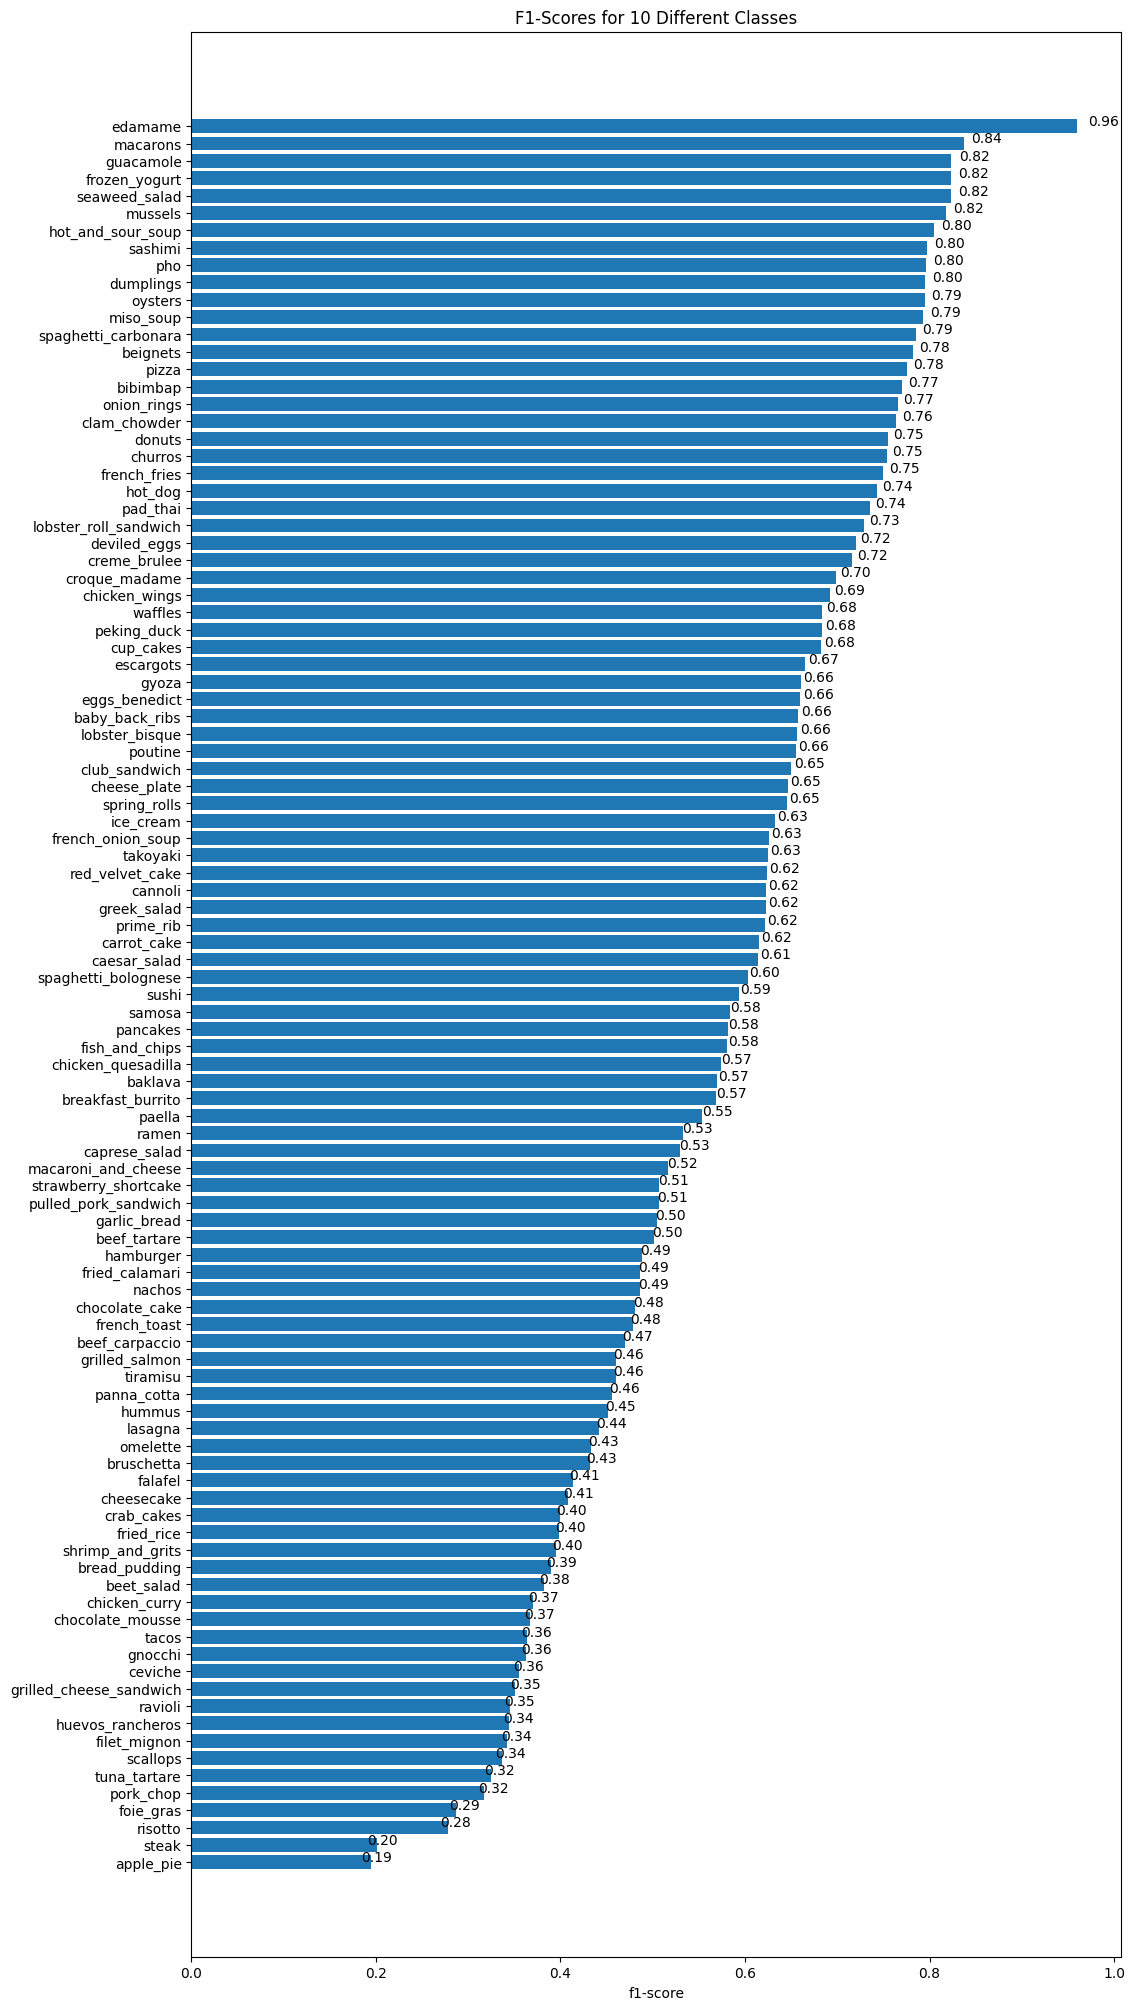

In [55]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)


In [56]:

def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 43ms/step


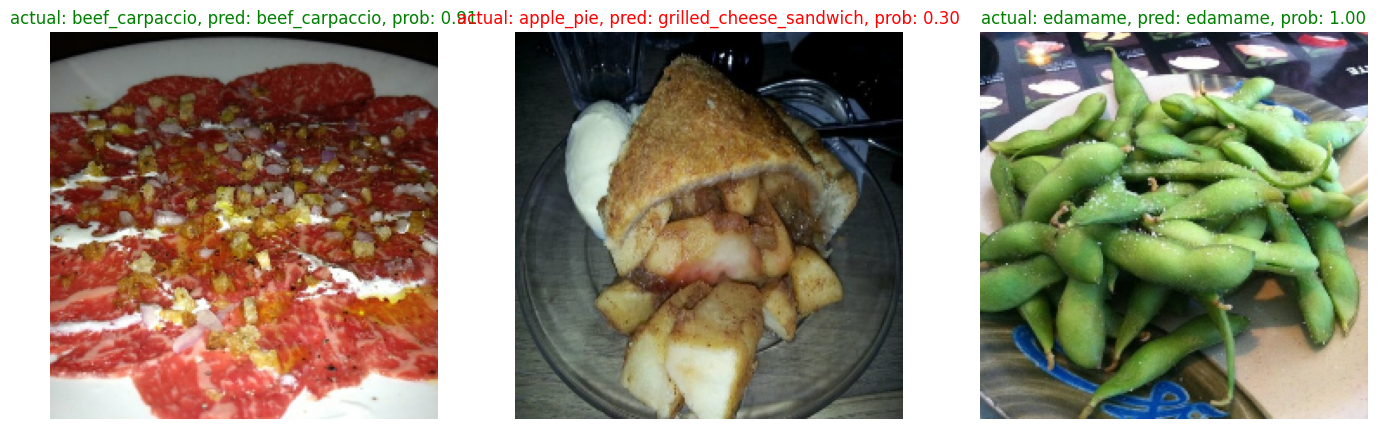

In [57]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [58]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [61]:

# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      85   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0      24   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      38   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

  y_true_classname y_pred_classname  
0        apple_pie           samosa  
1        apple_pie     clam_chowder  
2        apple_pie    bread_pudding  
3        apple_pie   fish_and_chips  
4        apple_pie    bread_pudding

In [62]:

# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      85   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0      24   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      38   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

  y_true_classname y_pred_classname  pred_correct  
0        apple_pie           samosa         False  
1        apple_pie     clam_chowder         False  
2        apple_pie    bread_pudding         False  
3        apple_pie   fish_and_chips         False  
4        apple_pie    bread_pudding         False